In [2]:
import os
import json

import pandas as pd
import openai
import anthropic
import fitz  
import tiktoken

import pymupdf4llm
from dotenv import load_dotenv

In [3]:
# Load API Keys
load_dotenv("key_file.env")

# Key for OpenAI models
openai_key = os.getenv("OPENAI_API_KEY")

# Key for Anthropic models (Claude)
anthropic_key = os.getenv("ANTHROPIC_KEY")


In [8]:
# Read Report (different packages can be used - experiment yourself what fits your needs best). It will take around 1-2 minutes.
# Usually that is how you would read from PDF - I already ran the code and saved the results in markdown format to accelerate the workshop

VCS2410 = pymupdf4llm.to_markdown("reports/VCS2410.pdf")
VCS2834 = pymupdf4llm.to_markdown("reports/VCS2834.pdf")
GCSP1025 = pymupdf4llm.to_markdown("reports/GCSP1025.pdf")

VCS2410 = pymupdf4llm.to_markdown("reports/VCS2410.pdf")
with open("reports/VCS2410.md", "w", encoding="utf-8") as f:
    f.write(VCS2410)

VCS2834 = pymupdf4llm.to_markdown("reports/VCS2834.pdf")
with open("reports/VCS2834.md", "w", encoding="utf-8") as f:
    f.write(VCS2834)

GCSP1025 = pymupdf4llm.to_markdown("reports/GCSP1025.pdf")
with open("reports/GCSP1025.md", "w", encoding="utf-8") as f:
    f.write(GCSP1025)



'\nVCS2410 = pymupdf4llm.to_markdown("reports/VCS2410.pdf")\nVCS2834 = pymupdf4llm.to_markdown("reports/VCS2834.pdf")\nGCSP1025 = pymupdf4llm.to_markdown("reports/GCSP1025.pdf")\n\nVCS2410 = pymupdf4llm.to_markdown("reports/VCS2410.pdf")\nwith open("reports/VCS2410.md", "w", encoding="utf-8") as f:\n    f.write(VCS2410)\n\nVCS2834 = pymupdf4llm.to_markdown("reports/VCS2834.pdf")\nwith open("reports/VCS2834.md", "w", encoding="utf-8") as f:\n    f.write(VCS2834)\n\nGCSP1025 = pymupdf4llm.to_markdown("reports/GCSP1025.pdf")\nwith open("reports/GCSP1025.md", "w", encoding="utf-8") as f:\n    f.write(GCSP1025)\n\n'

In [5]:
NECP = pymupdf4llm.to_markdown("reports/Germany_NECP_2024.pdf")
NHS = pymupdf4llm.to_markdown("reports/Germany_NHS_2023.pdf")

In [7]:
project_dict = { 'NECP': NECP, 
                 'NHS': NHS
                }

# 1. Estimating API Request Costs of Reading Different Carbon Project Descriptions

Using the API of Large Language Models always comes with a cost. However, different models are priced differently.  
To use an LLM, one needs to create an account, generate an API key, and add credit to the account.  
A tutorial for GPT is [here](https://www.merge.dev/blog/chatgpt-api-key), and one for Anthropic is [here](https://www.merge.dev/blog/anthropic-api-key).

**Never** upload your key anywhere (e.g. github, paper submission...), if it gets exposed people can use credit from your account!

Length of Documents (PDFs include images, tables, etc.):
- NECP: 372 pages
- NHS: 34 pages

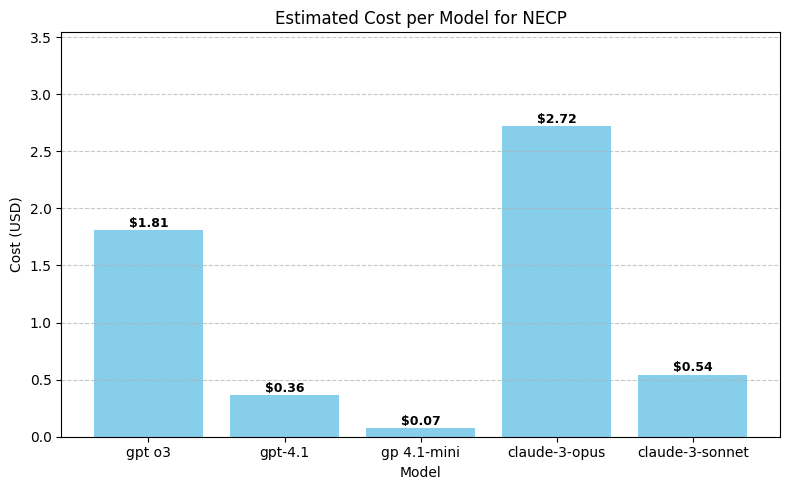

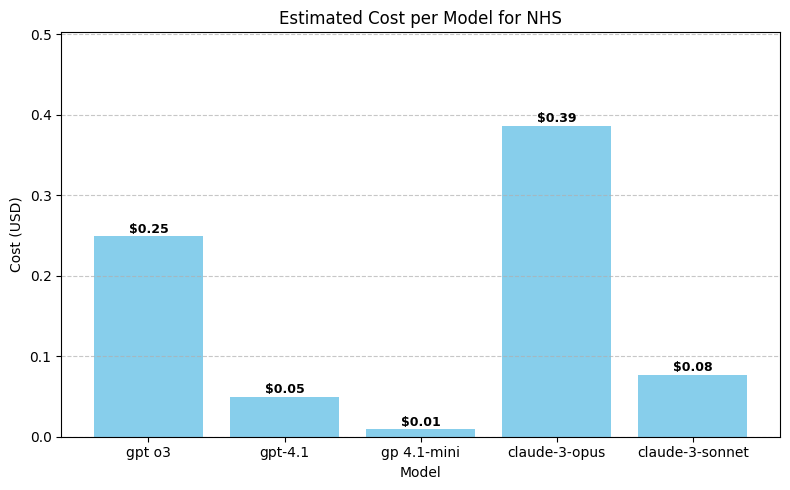

In [8]:
import tiktoken
import matplotlib.pyplot as plt


#TODO
expected_output_tokens = 800  # You can adjust this if needed

# === Pricing Table (as of May 2025) ===
pricing = { 
        "gpt o3": {"input": 10.0, "output": 40.0},
        "gpt-4.1": {"input": 2.0, "output": 8.0},
        "gp 4.1-mini": {"input": 0.4, "output": 1.6},
        "claude-3-opus": {"input": 15.0, "output": 75.0},
        "claude-3-sonnet": {"input": 3.0, "output": 15.0},
    }


# Store data for plotting
plot_data = {}

encoding = tiktoken.get_encoding("cl100k_base")

# Process each document and model
for text_name, input_text in project_dict.items():
    plot_data[text_name] = {}
    input_tokens = encoding.encode(input_text)
    num_input_tokens = len(input_tokens)

    for model in pricing.keys():
        price_per_1k = pricing[model]
        cost_input = (num_input_tokens / 1_000_000) * price_per_1k["input"]
        cost_output = (expected_output_tokens / 1_000_000) * price_per_1k["output"]
        total_cost = cost_input + cost_output
        plot_data[text_name][model] = total_cost

# Plotting with value annotations
for text_name, costs in plot_data.items():
    models_list = list(costs.keys())
    cost_values = list(costs.values())

    plt.figure(figsize=(8, 5))
    bars = plt.bar(models_list, cost_values, color='skyblue')
    plt.title(f"Estimated Cost per Model for {text_name}")
    plt.ylabel("Cost (USD)")
    plt.xlabel("Model")
    plt.ylim(0, max(cost_values) * 1.3)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add cost annotations on top of bars
    for bar, cost in zip(bars, cost_values):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.0002, f"${cost:.2f}",
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()


# 2. System Prompts and Temperature

Excercises:

1. System Prompt: Play with the system prompt.
2. Use different values for temperature (0-1). What do you observe?


In [12]:

# === Function to get the answer from the model ===
client = openai.OpenAI(api_key=openai_key)

user_prompt = "What color is the sky?"


# TODO 1: Play around with different system prompts. Use the proposed prompts or  - how does it change the output?
system_prompt = "You are a helpful assistant. Answer the question directly."
#system_prompt = "You are a poet. Don't answer the question directly, but answer in vague poems."
#system_prompt = "You are a extremely accurate researcher. Answer the question and cover all caveats."“#
#system_prompt = "You are a Swiss German translator. Translate all inputs to Swiss German without adding content."

# TODO 2: Play around with different temperatures. Use a more creative system prompt (e.g. the poet one). How does it change the output?
temperature_value = 0



messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_prompt}
 
                        ]


MODEL = "gpt-4"  # Choose the model you want to use
response = client.beta.chat.completions.parse(
                        model=MODEL,
                        messages= messages,
                        temperature=temperature_value,
                        max_tokens=1000,
                        )
output = response.choices[0].message.content

print(output)

The sky is blue.


## 3. Get structured information from PDFs without structured output

Our main goal is obtaining structured information from unstructured text. Here we use the National Hydrogen Stragegy, to extract policy targets and instruments.

Excercise: Refine the user_prompt to align with your research goal - i based it on Alejandros email but am not sure if I got it correctly

In [13]:
# TODO: Refine prompts, I implemented them like I understand your goal from your email. I am not sure if you want to match the policy instruments to the policy target or if you want to extract them separately. Make that clear in the prompt.
system_prompt =  "You are a research assistant. Base all your answers on information from the policy documents. Do not add any information that is not in the policy documents. If you are not sure, write 'Not found'."


user_prompt =  """ 
<objective>
Your task is to extract information from the policy documents. We are interested in the following information:
- Policy Targets
- Policy Instruments

</objective>

<instructions>
First identify the policy targets and find the policy instruments that are used to achieve the targets, and classify the instruments based on the categories given below. Give a short description of the policy instruments with quotes from the text you base your answer on.
</instructions>

<definitions>
- Policy Targets: An intended policy outcome in specific, measurable, and time-bounded terms. A policy target is specific and concrete,  related to the outcome of the policy and not the funding or the policy itself. For example, road transportation emissions will be reduced by 30% from the 1990 levels by 2050.

- Policy instruments: An action by governments to influence the behavior of one or more societal actors through specific mechanisms foreseen in the legal and institutional framework of the relevant jurisdiction. For example, a tax credit for purchases of new electric vehicles.

- Policy instrument categories: The policy instruments are classified into the following categories:

    - "Education and outreach": Policies designed to increase knowledge, awareness, and training among relevant stakeholders or users,including information campaigns, training programs, labelling schemes.		

    - "Financial": Policies to encourage or stimulate certain activities or behaviours. These include tax incentives, such as tax exemptions, eductions or credits on the purchase or installation of certain goods and services.	

    - "Incentives and subsidies": Policies to stimulate certain activities, behaviours or investments. These include feed-in tariffs for renewable energy, rebates for the purchase of energy-efficient appliancegrants	 and preferential loans and third-party financing.			

    - "Framework policy": Refers to the processes undertaken to develop and implement policies. This generally covers strategic planning documents and strategies that guide policy development. It can also include the creation of specific bodies to further policy aims	 making strategic modifications	 or developing specific programs.					

    - "Public investment": Policies guiding investment by public bodies. These include government procurement programs (e.g. requirement to purchase energy efficient equipment and vehicles) and infrastructure investment (e.g. urban planning).							

    - "RD&D": Policies and measures for the government to invest directly in or facilitate investment in technology research	 development	 demonstration and deployment activities.					

    - "Regulatory instruments": Covers a wide range of instruments by which a government will oblige actors to undertake specific measures and/or report on specific information. Examples include energy performance standards for appliance, equipment, and buildings, obligations on companies to reduce energy consumption, produce or purchase a certain amount of renewable energy, mandatory energy audits of industrial facilities, requirements to report on GHG emissions or energy use.				

    - "Tradable permits": Refers to three kinds of systems,  GHG emissions trading schemes, white certificate systems stemming from energy efficiency or energy savings obligations, and green certificate systems based on obligations to produce or purchase renewable energy-sourced power (generally electricity). In GHG trading schemes, industries must hold permits to cover their GHG emissions; if they emit more than the amount of permits they hold, they must purchase permits to make up the shortfall. If they emit less, they may sell these. White certificate schemes create certificates for a certain quantity of energy saved, for example one MWh, regulated entities must submit enough certificates to show they have met energy saving obligations. Again, if they are short, this must be made-up through measures that reduce energy use, or through purchase of certificates. Green certificates refer to renewable energy certificates that represent the certified generation of one unit of renewable energy, generally one megawatt-hour. Certificates can be traded among consumers and/or producers and used to meet renewable energy obligations."

    - "Voluntary agreements": Refers to measures that are undertaken voluntarily by government agencies or industry bodies, based on a formalized agreement. There are incentives and benefits to undertaking the action, but generally few legal penalties in case of non-compliance. The scope of the action tends to be agreed upon in concert with the relevant actors. These are often agreed to between a government and an industry body	 with the latter agreeing to certain measures; for example reporting information on energy use to the government, being subject to audits, and undertaking measures to reduce energy use. 
    
    - "Other": Refers to any other policy instruments that fall into none of the other categories. Try to use the categories above, but if you cannot find a suitable category, use this one. 

<definitions>

<Policy Document>
The carbon policy documents starts here: \n 


    
"""

In [14]:
# We are using the first 100000 characters of the project description to reduce costs for the sake of the workshop
full_prompt = user_prompt + f" {NHS} \n </Policy Document>"


client = openai.OpenAI(api_key=openai_key)
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": full_prompt}
    
                        ]


MODEL = "gpt-4.1-2025-04-14"  # Choose the model you want to use
response = client.beta.chat.completions.parse(
                        model=MODEL,
                        messages= messages,
                        temperature=0,
                        max_tokens=10000,
                        )

output = response.choices[0].message.content

print(output)

Below is a structured extraction of the policy targets and policy instruments from the provided policy document, with classification and supporting quotes.

---

## Policy Targets

1. **Accelerated market ramp-up of hydrogen**
   - "The market ramp-up of hydrogen, its derivatives and hydrogen application technologies will be significantly accelerated and the level of ambition along the entire value chain massively increased."

2. **Ensuring sufficient availability of hydrogen and its derivatives**
   - "The target for domestic electrolyser capacity in 2030 will be increased from 5 GW to at least 10 GW. The remaining demand will be covered by imports. A separate import strategy will be developed."

3. **Development of an efficient hydrogen infrastructure**
   - "By 2027/2028, a hydrogen start-up grid with more than 1,800 km of repurposed and newly built hydrogen pipelines will be set up in Germany using IPCEI funding; approx. 4,500 km will be added throughout Europe (European Hydrogen B

# 4. Adding structured output

Now we add a output schema to the LLM instruction. This enables us to read model output to dataframe.

Excercise: read output structure and understand how output is transformed into a dataframe

In [15]:
output_structure = """ 

<output schema>
\n 

Please strictly follow this json output structure - don't add any other information or text to your output:

{
"actors": [
        {
            "Policy Target": "policy target A",
            "Policy Target description": "description of the policy target A with quotes from the text",
            "Policy Instrument": "Description of the policy instrument A with quotes from the text",
            "Policy Instrument category": "classification of Policy Instrument A",
        }
    ]
}
</output schema>
"""


In [16]:
full_prompt =  user_prompt + f" {NHS} \n </Policy Document>" + output_structure
system_prompt = "You are a research assistant. Base all your answers on information carbon project descriptions. Do not add any information that is not in the project description. If you are not sure, write 'Not found'."

messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": full_prompt}
    
                        ]


MODEL = "gpt-4.1-2025-04-14"  # Choose the model you want to use
response = client.beta.chat.completions.parse(
                        model=MODEL,
                        messages= messages,
                        temperature=0,
                        max_tokens=10000,
                        )

# Read LLM output
output = response.choices[0].message.content

# Extract the JSON part from the output
cleaned_output = output.strip("```json").strip("```").strip()
data = json.loads(cleaned_output)

df_policy_targets=pd.json_normalize(data['actors'])


df_policy_targets

,Policy Target,Policy Target description,Policy Instrument,Policy Instrument category
0,"Accelerated market ramp-up of hydrogen, its de...","""the market ramp-up of hydrogen, its derivativ...","Direct funding of electrolysers, both those lo...",Incentives and subsidies
1,Ensuring sufficient availability of hydrogen a...,"""the target for domestic electrolyser capacity...",IPCEI Hydrogen funding for electrolysis projec...,Incentives and subsidies
2,Development of an efficient hydrogen infrastru...,"""by 2027/2028, a hydrogen start-up grid with m...",Amendment of energy industry law to create the...,Regulatory instruments
3,Implementation of hydrogen applications in the...,"""by 2030, hydrogen and its derivatives will be...",Climate protection contracts for industry (Car...,Financial
4,Germany will become the lead provider of hydro...,"""German suppliers are increasing their technol...",Further development of the national H2Giga ele...,RD&D
5,Creation of appropriate framework conditions: ...,"""coherent regulatory conditions at national, E...",Hydrogen Acceleration Act to bring about an ap...,Framework policy
6,"By 2030, a total hydrogen demand of 95-130 TWh...","""For the NHS update, a total hydrogen demand o...",Import strategy for hydrogen and hydrogen deri...,Incentives and subsidies
7,Establishment of a common market with uniform ...,"""A common market with uniform standards for gr...",Development and implementation of sustainabili...,Regulatory instruments
8,"Strengthening research, innovation and trainin...","""Strengthening research, innovation and furthe...","Funding of hydrogen flagship projects (H2Giga,...",RD&D
9,Development of a hydrogen refuelling infrastru...,"""Implementing short-term measures to ensure th...",Funding programmes for the expansion of hydrog...,Incentives and subsidies


In [17]:
#To evaluate the output it is probably best to copy to excel/google sheets for easier reading
df_policy_targets.to_clipboard()

                                        Policy Target  \
0   Accelerated market ramp-up of hydrogen, its de...   
1   Ensuring sufficient availability of hydrogen a...   
2   Development of an efficient hydrogen infrastru...   
3   Implementation of hydrogen applications in the...   
4   Germany will become the lead provider of hydro...   
5   Creation of appropriate framework conditions: ...   
6   By 2030, a total hydrogen demand of 95-130 TWh...   
7   Establishment of a common market with uniform ...   
8   Strengthening research, innovation and trainin...   
9   Development of a hydrogen refuelling infrastru...   
10  By 2030, hydrogen and its derivatives will be ...   
11  Municipal heat planning to be introduced natio...   
12  Accelerate planning and approval procedures fo...   
13  Development of an internationally recognised a...   
14  Increase the size of the skilled workforce for...   

                            Policy Target description  \
0   "the market ramp-up of hyd

# 5. Run for different projects

Run the box below try to understand how to add the output of different documents and LLM API requests to one dataframe.

You don't need to run this during the workshop - if you ever do a project with LLMs this code can be a starting point

Remember from task on: Processing NECP is rather costly - think first before running the model too many times and experient on the short document first. Alternatively split the document for experiments.

In [19]:
# Define the 
df_policy_targets = pd.DataFrame(columns=['Document Type','Policy Target','Policy Target description','Policy Instrument','Policy Instrument category'])

for project in project_dict.keys():
    print('Processing project :', project)
    project_text = project_dict[project]
    user_prompt = user_prompt + f" {project_text} \n </Policy Document>" + output_structure
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    MODEL = "gpt-4.1-2025-04-14"  # Choose the model you want to use
    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=messages,
        temperature=0,
        max_tokens=10000,
    )

    output = response.choices[0].message.content

    cleaned_output = output.strip("```json").strip("```").strip()

    data = json.loads(cleaned_output)

    df_output=pd.json_normalize(data['actors'])
    df_output['Document Type'] = project  # Add project ID to the DataFrame

    df_policy_targets = pd.concat([df_policy_targets, df_output], ignore_index=True)

df_policy_targets

Processing project : NECP
Processing project : NHS


,Policy Target,Policy Target description,Policy Instrument,Policy Instrument category,project_id
0,Double domestic electrolyser capacity to at le...,"""we are doubling the electrolyser target for t...","Direct funding of electrolysers, both those lo...",Incentives and subsidies,NECP
1,Cover remaining hydrogen demand in 2030 (total...,"""around 50 to 70 percent (45 to 90 TWh) of the...",Development and implementation of a hydrogen i...,Framework policy,NECP
2,Establish a national hydrogen core network and...,"""by 2027/2028, a hydrogen start-up grid with m...",Amendment of energy industry law to create the...,Regulatory instruments,NECP
3,Accelerate market ramp-up and application of h...,"""by 2030, hydrogen and its derivatives will be...",Financial support for hydrogen applications th...,Incentives and subsidies,NECP
4,Establish Germany as a lead provider of hydrog...,"""Germany will become the lead provider of hydr...","Support for research, innovation, and training...",RD&D,NECP
5,Create effective framework conditions for hydr...,"""the hydrogen market ramp-up requires effectiv...",Hydrogen Acceleration Act to simplify and acce...,Regulatory instruments,NECP
6,Increase domestic electrolyser capacity for gr...,"""we are doubling the electrolyser target for t...","Direct funding of electrolysers, both those lo...",Incentives and subsidies,NHS
7,"Cover remaining hydrogen demand by imports, wi...","""around 50 to 70 percent (45 to 90 TWh) of the...",Development and implementation of an import st...,Framework policy,NHS
8,"Develop a national hydrogen infrastructure, in...","""Energy industry law is to be amended this yea...",Amendment of energy industry law to create the...,Regulatory instruments,NHS
9,Develop a European Hydrogen Backbone network w...,"""The first stage of development in this endeav...","Support for cross-border pipeline projects, bi...",Framework policy,NHS


# 6. Extract and process images from Project Description

There are not too many images in your texts, that is why I did not implement this for the policy documents. Either continue to play around with prompts, evaluate results for follow the last task of the workshop using the Carbon Project case.

Note: Here we read two images that are saved in in the project folder. The pipeline to get to those two images (not detailed here) was:
1. Read all images from the pdf (using python package fitz)
2. Classify each image in "relavant" or "irrelevant" with low cost LLM (gpt-4.1 mini) to reduce overall project costs and don't exceed context window limits - most images in project descriptions are irrelevant for our research question.
3. Save images locally 

If you are interested in this part of the pipeline, feel free to approach me. I am happy to tell you more about it or share code snippets.

In [20]:
pdf_file = "reports/GCSP1025.pdf"


import fitz  # PyMuPDF
import base64
import io
from PIL import Image
import pandas as pd
import json
client = openai.OpenAI(api_key=openai_key)


pdf_file = "reports/GCSP1025.pdf"

# Extract images from PDF
def load_images_from_folder(folder_path):
    image_entries = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            with open(os.path.join(folder_path, filename), "rb") as img_file:
                encoded_string = base64.b64encode(img_file.read()).decode("utf-8")
                image_entries.append({
                    "image_base64": encoded_string,
                    "filename": filename
                })
    return image_entries

# Example input values
project_id = "GCSP1025"
image_folder = f"reports/{project_id}_relevant_images"
images = load_images_from_folder(image_folder)




for project in ['GCSP1025']:
    project_text = project_dict[project]
    user_prompt = system_prompt + category_description + f" The carbon project description starts here: \n {project_text}" + "Also consider the information from the images. "+ output_structure

    # Prepare message with image(s)
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]

    # If images should be included as separate messages
    for img in images:
        messages.append({
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{img['image_base64']}"
                    }
                }
            ]
        })

    MODEL = "gpt-4.1-2025-04-14"
    response =  client.beta.chat.completions.parse(
        model=MODEL,
        messages=messages,
        temperature=0,
        max_tokens=10000,
    )

    output = response.choices[0].message.content
    cleaned_output = output.strip("```json").strip("```").strip()
    data = json.loads(cleaned_output)

    df_output = pd.json_normalize(data['actors'])

df_output
